In [91]:
import string
from collections import Counter
import os
import pickle

import numpy as np
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#
# Domain specific libraries to handle text
#
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

# ML Librairies

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold 
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn import metrics

import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [62]:
seed=23
np.random.seed(seed)

# Preprocessing

Data formatting

In [2]:
unhealthy = pd.read_excel('/Users/victor/Documents/GitHub/SP-Global-Ops-Consulting/data/Fund Articles_Unhealthy_New.xlsx')
healthy = pd.read_excel('/Users/victor/Documents/GitHub/SP-Global-Ops-Consulting/data/Funds Articles_Healthy_New.xlsx')
healthy.drop('Unnamed: 1',axis=1,inplace=True)


In [3]:
healthy['article']=healthy['Healthy Fund Articles']
healthy.drop('Healthy Fund Articles',axis=1,inplace=True)
unhealthy['article']=unhealthy['Unhealthy Fund Articles']
unhealthy.drop('Unhealthy Fund Articles',axis=1,inplace=True)


In [4]:
healthy['label']=1
unhealthy['label']=0

In [5]:
df = pd.concat([healthy,unhealthy],axis=0).reset_index(drop=True)

In [6]:
df.head()

,article,label
0,Mitel Returns To Profit In The Second Quarter ...,1
1,TriplePoint Venture Growth BDC Corp. Announces...,1
2,"@ M&A wrap: Sycamore, Staples, Leonardo DiCapr...",1
3,GTIS Partners LP Broadens Business Model; Anno...,1
4,@ Cinven to buy Dublin-headquartered Axa Life ...,1


In [7]:
y = df['label']

Train/Test Division

In [99]:
train_df = pd.DataFrame()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['article'], y, test_size=0.33, random_state=53)

NLP

In [9]:
punctuation=list(string.punctuation)
digits= list(string.digits)
stop_words=stopwords.words("english")+punctuation+['``',"''",'--']+digits

In [10]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In [11]:
def stem_tokenizer(text):
    porter_stemmer=PorterStemmer()
    return [porter_stemmer.stem(token) for token in word_tokenize(text.replace("'"," "))]

Word Count Representation

In [12]:
countVectorizer=CountVectorizer(input='content',tokenizer=lemma_tokenizer,stop_words=stop_words)
count_train =countVectorizer.fit_transform(X_train.values)
count_test =countVectorizer.transform(X_test)

In [107]:
countVectorizer2=CountVectorizer(input='content',tokenizer=lemma_tokenizer,stop_words=stop_words,ngram_range=(2,2))
count_train2 =countVectorizer.fit_transform(X_train.values)
count_test2 =countVectorizer.transform(X_test)

TFIDF Representation

In [13]:
tfidfVectorizer=TfidfVectorizer(input="content",tokenizer=lemma_tokenizer,stop_words=stop_words)
tfidf_train= tfidfVectorizer.fit_transform(X_train.values)
tfidf_test = tfidfVectorizer.transform(X_test)

# Machine Learning

## 1) Naive Bayes 

In [87]:
NB = MultinomialNB()
NB.fit(count_train, y_train)
Y_pred_NB = NB.predict(count_test)
print('Accuracy:', np.average(Y_pred_NB==y_test))
print('Recall:', metrics.recall_score(y_test, Y_pred_NB))

Accuracy: 0.835692171605
Recall: 0.932960893855


In [108]:
NB = MultinomialNB()
NB.fit(count_train2, y_train)
Y_pred_NB = NB.predict(count_test2)
print('Accuracy:', np.average(Y_pred_NB==y_test))
print('Recall:', metrics.recall_score(y_test, Y_pred_NB))

Accuracy: 0.835692171605
Recall: 0.932960893855


Confusion matrix, without normalization
[[2109  623]
 [ 120 1670]]


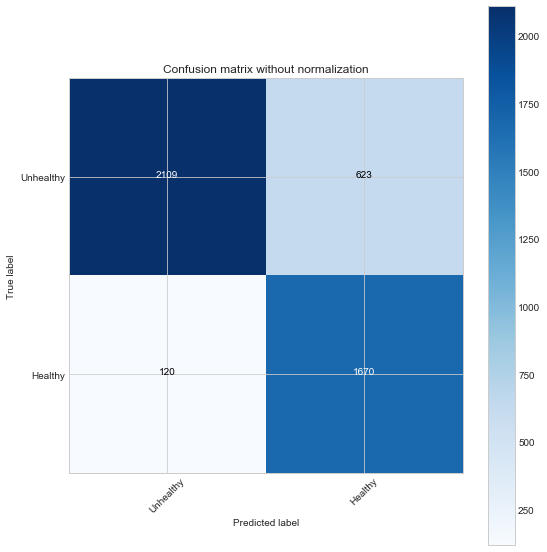

In [89]:
cnf_matrix = confusion_matrix(y_test, Y_pred_NB)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes = ['Unhealthy','Healthy'],title='Confusion matrix without normalization')
plt.show()

In [101]:
train_df['NB_Pred']= Y_pred_NB

With Cross Validation

In [115]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [116]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True)
for dev_index, val_index in kf.split(count_train):
    dev_X, val_X = count_train[dev_index], count_train[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, count_test)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## 2) Logistic Regression

In [103]:
clf = LogisticRegression(C=0.1)
clf.fit(count_train, y_train)
Y_pred_LR = clf.predict(count_test)
print('Accuracy:', np.average(Y_pred_LR==y_test))
print('Recall:', metrics.recall_score(y_test, Y_pred_LR))

Accuracy: 0.926138876603
Recall: 0.903351955307


Confusion matrix, without normalization
[[2571  161]
 [ 173 1617]]


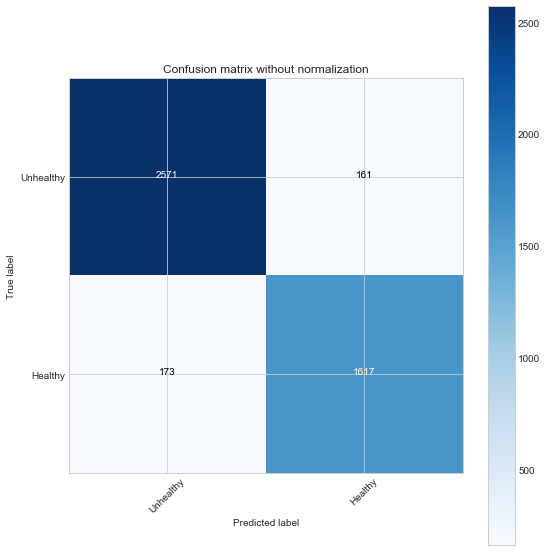

In [104]:
cnf_matrix = confusion_matrix(y_test, Y_pred_LR)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes = ['Unhealthy','Healthy'],title='Confusion matrix without normalization')
plt.show()

In [105]:
train_df['Logistic Regression']=Y_pred_LR

## 3) SVD-SVM

In [94]:
svd = TruncatedSVD(n_components=200)
svd.fit(tfidf_train)
xtrain_svd = svd.transform(tfidf_train)
xtest_svd = svd.transform(tfidf_test)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [82]:
clf = SVC(C=10)
clf.fit(xtrain_svd_scl, y_train)
Y_pred_SVM = clf.predict(xtest_svd_scl)


print('Accuracy:', np.average(Y_pred==y_test))
print('Recall:', metrics.recall_score(y_test, Y_pred_SVM))

Accuracy: 0.920168067227
Recall: 0.883240223464


Confusion matrix, without normalization
[[2580  152]
 [ 209 1581]]


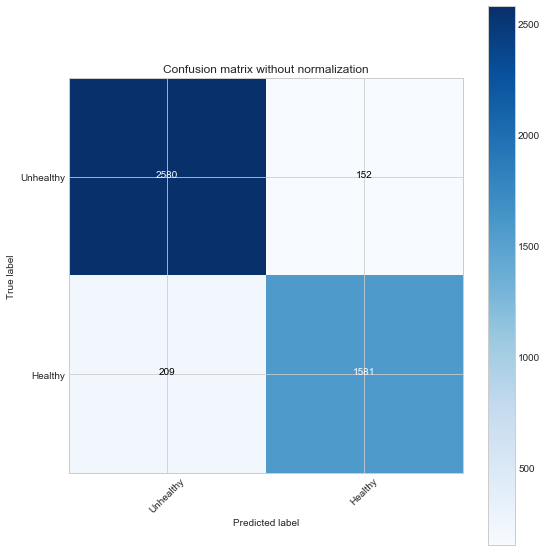

In [84]:
cnf_matrix = confusion_matrix(y_test, Y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes = ['Unhealthy','Healthy'],title='Confusion matrix without normalization')
plt.show()

## 4) XGBoost 

In [97]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, y_train)
Y_pred_XGB = clf.predict(xtest_svd)


print('Accuracy:', np.average(Y_pred_XGB==y_test))
print('Recall:', metrics.recall_score(y_test, Y_pred_XGB))

Accuracy: 0.911322423706
Recall: 0.863687150838


# New Model With Feature Engineering

Since the tfidf vectors are sparse, one another way of compressing the information and representing it in a much compact way is through SVD. So we could created svd features on word tfidf and add them to our feature set.

In [119]:
svd = TruncatedSVD(n_components=10, algorithm='arpack')
svd.fit(tfidf_train)

train_svd = pd.DataFrame(svd.transform(tfidf_test))
test_svd = pd.DataFrame(svd.transform(tfidf_test))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(10)]
test_svd.columns = ['svd_word_'+str(i) for i in range(10)]
train_df_2 = pd.concat([train_df, train_svd], axis=1)
test_df_2 = pd.concat([test_df, test_svd], axis=1)

NameError: name 'test_df_2' is not defined